# Colony Counter

John Russell
2018-08-01

This is a **highly imperfect** script to count colonies on scanned agar plates. It's is designed to work well with 6 plates that were scanned. 

Dependencies:

* `python2.7`
* `numpy`
* `matplotlib`
* `scikit-image`

In [1]:
#Load the basics
import numpy as np
import matplotlib.pyplot as plt
import skimage
from matplotlib import rc
rc("text", usetex=True)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

In [435]:
#Load skimage stuff
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny

In [436]:
path_to_plate = "plate.tif"
plate = plt.imread(path_to_plate)
g_plate = rgb2gray(plate) # convert to grayscale
#six_plates = rescale(g_plate,.5) #if you want to downsample, it will speed things up

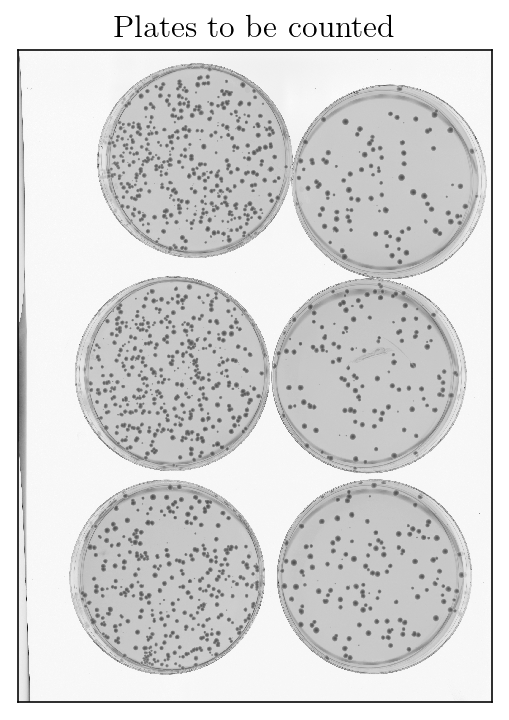

In [439]:
plt.imshow(g_plate, cmap="Greys")
plt.xticks([])
plt.yticks([])
plt.title(r"Plates to be counted",fontsize=16)
plt.show()

In [390]:
def circ_mask(shape, cx, cy, r):
    """
    Make circular masks to count each plate individually.
    """
    
    mask = np.zeros((len(cx),)+shape)
    X,Y = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
    for i,(x,y,rad) in enumerate(zip(cx,cy,r)):
        sing_mask = np.sqrt((X-x)**2+(Y-y)**2)
        mask[i] =(sing_mask < rad)
    return mask

In [393]:
def get_centers(cx,cy,r_list,d=490):
    """
    Find the centers of the six individual plates
    The Hough Circle Transformation sometimes double counts plates
    before finding the centers of all plates. This checks that the 
    identified centers correspond to different plates
    """
    centers = [(cx[0],cy[0])]
    radii = [r_list[0]]
    for i,(x,y) in enumerate(zip(cx[1:],cy[1:])):
        new = True
        for c in centers:
            if np.sqrt((x-c[0])**2 + (y-c[1])**2) < d: 
                new = False
                break
        if new:
            centers.append((x,y))
            radii.append(r_list[i])
    centers = np.array(centers)
    return centers[:,0],centers[:,1],radii

In [433]:
colors = ["red","blue", "green", "magenta", "cyan", "yellow"]

def count_colonies(plate_im,show_result=True):
    """
    Count the colonies in a scanned image of plates. Should work with any number of plates.
    
    arguments:
    
    plate_im : greyscale image of the plates you want to count
    
    show_results : Do you want to see the colonies called for each plates. Default True. 
    """
    
    #Find the different plates and create a mask for each one
    edges = canny(plate_im)
    dish_rad = [480]
    hough_res = hough_circle(edges, dish_rad)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, dish_rad,num_peaks=12) #seemed to be a safe number
    CX, CY, R = get_centers(cx,cy,radii)
    
    N_plates = len(R)
    print "Plates detected: {}".format(N_plates) 
    
    mask = circ_mask(plate_im.shape, CX, CY, R)

    
    if show_result:
        fig, ax = plt.subplots(1,1)
        ax.imshow(plate_im,cmap="Greys")
        ax.set_axis_off()
        
    for i in range(N_plates):
        trimmed = mask[i]*plate_im #Crop this image to make it faster (I think)
        
        blobs = blob_log(trimmed, max_sigma=15, min_sigma=2, threshold=0.1)
        blobs[:,2] = np.sqrt(2)*blobs[:,2]
        print str(len(blobs))+" Colonies Detected. Shown in {}".format(colors[i])
        
        if show_result:
            
            for blob in blobs:
                y,x,r = blob
                C = plt.Circle((x,y),r, color=colors[i], linewidth=1, fill= False)
                ax.add_patch(C)

    if show_result:
        plt.show()    

Plates detected: 6
173 Colonies Detected. Shown in red
236 Colonies Detected. Shown in blue
228 Colonies Detected. Shown in green
355 Colonies Detected. Shown in magenta
403 Colonies Detected. Shown in cyan
483 Colonies Detected. Shown in yellow


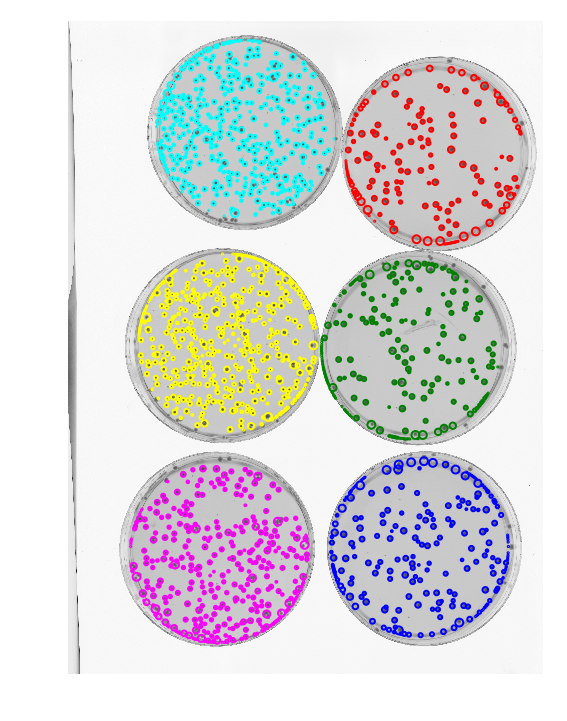

In [434]:
count_colonies(g_plate)

### Make it object oriented like you're supposed to...

I might even do this

In [228]:
class plate_reader:
    def __init__(self, plate_im):
        self.plates = plate_im
    